In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from prophet import Prophet

In [2]:
ctg=pd.read_csv('CTG.csv')
ctg

,Ticker,Date,Open,High,Low,Close,Volume
0,CTG,7/16/2009,10.470000,11.778750,10.470000,10.496170,2401900.0
1,CTG,7/17/2009,10.103510,10.208210,9.972637,9.972637,1002480.0
2,CTG,7/20/2009,9.475024,9.475024,9.475024,9.475024,156560.0
3,CTG,7/21/2009,9.004166,9.292089,9.004166,9.135040,2133390.0
4,CTG,7/22/2009,9.291805,9.396502,9.160935,9.265632,949090.0
...,...,...,...,...,...,...,...
3654,CTG,03/07/2024,36.000000,36.050000,35.450000,35.800000,8882900.0
3655,CTG,03/08/2024,35.800000,35.850000,34.500000,34.500000,20828300.0
3656,CTG,03/11/2024,34.500000,34.750000,33.900000,34.150000,7842600.0
3657,CTG,03/12/2024,34.000000,34.600000,33.950000,34.500000,6760600.0


In [3]:
ctg= ctg[['Date', 'Close']]
ctg['Date'] = pd.to_datetime(ctg['Date'])

C:\Users\DELL\AppData\Local\Temp\ipykernel_18808\2366246511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctg['Date'] = pd.to_datetime(ctg['Date'])


In [6]:
split_time = 3000
train = ctg[:split_time]
test = ctg[split_time:]

train.shape, test.shape

((3000, 2), (659, 2))

In [7]:
pio.templates.default = "plotly_white"

st_fig = go.Figure()

line1 = go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train')
line2 = go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test')

st_fig.add_trace(line1)
st_fig.add_trace(line2)
st_fig.update_layout(title='Daily Close Stock Price CTG Period 2009-2024')
st_fig.show()

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


C:\Users\DELL\AppData\Local\Temp\ipykernel_18808\2145288333.py:10: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



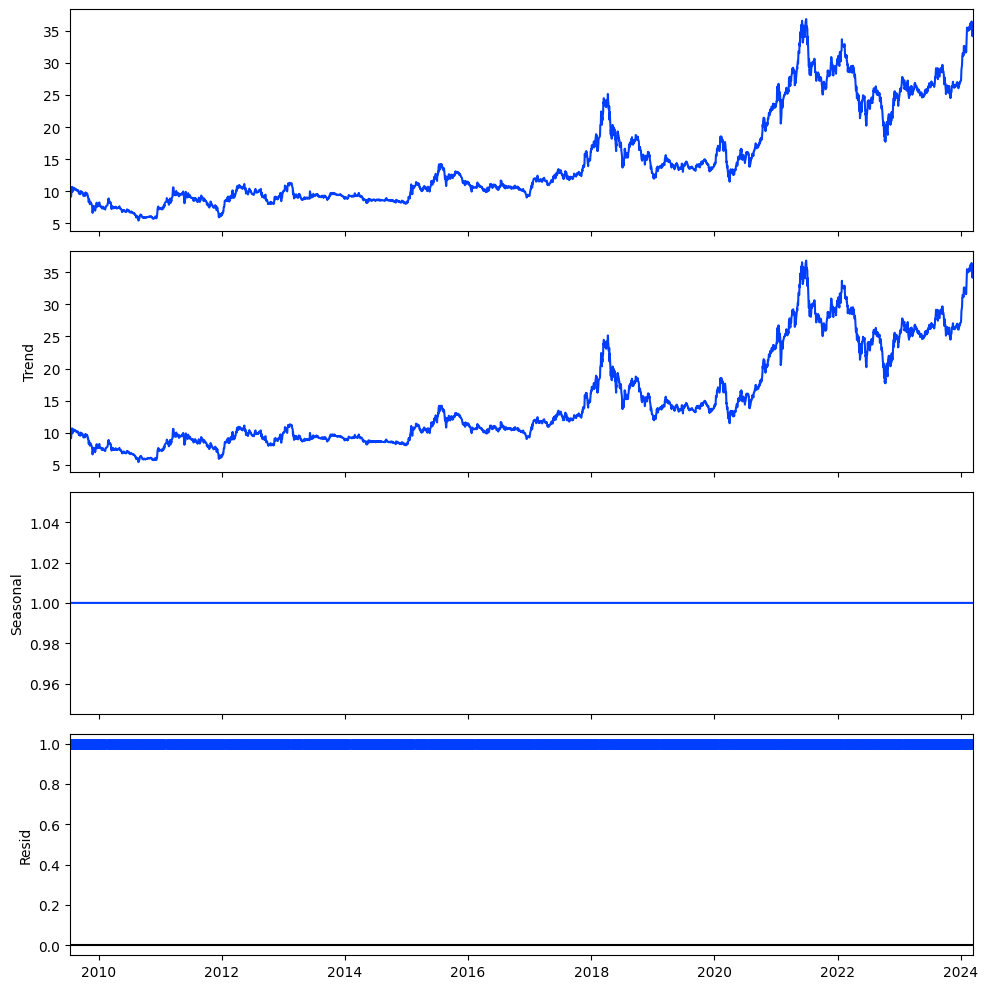

In [8]:
print(plt.style.available)
sd = ctg.copy().dropna()
sd.set_index('Date', inplace=True)

plt.style.use("seaborn-v0_8-bright")
plt.rc("figure", figsize=(10,10))

fig = seasonal_decompose(sd, model='multiplicative', period=1).plot()

fig.show()

# **ARIMA**

In [9]:
result = adfuller(train['Close'])
print(f'ADF Stattistics : {result[0]}')
print(f'P-value : {result[1]}')

result_kpss = kpss(train['Close'])
print(f'KPSS Stattistics : {result_kpss[0]}')
print(f'P-value : {result_kpss[1]}')

ADF Stattistics : -0.13429123305174376
P-value : 0.945914060370714
KPSS Stattistics : 5.7068777291793165
P-value : 0.01


C:\Users\DELL\AppData\Local\Temp\ipykernel_18808\4195365602.py:5: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




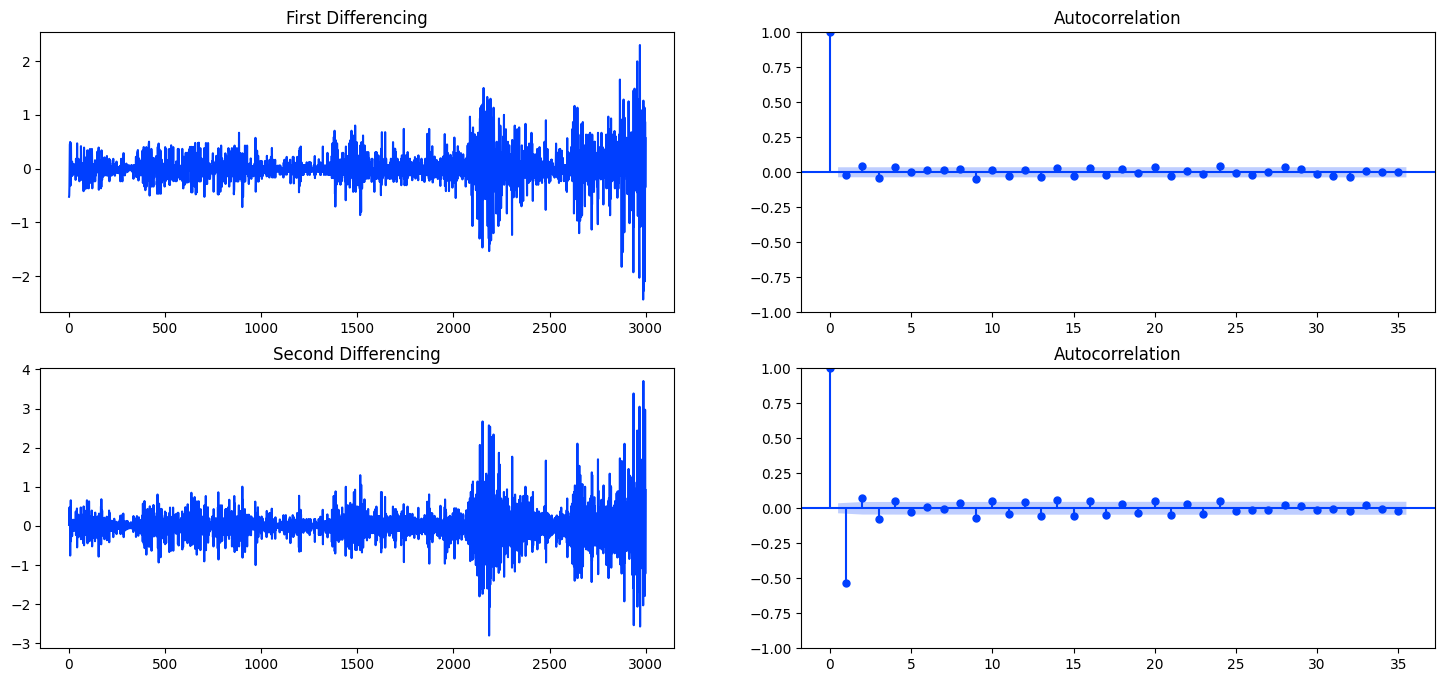

In [10]:
# Plot ACF
fig, ax = plt.subplots(2, 2, figsize=(18,8))

diff_once = train['Close'].diff()
ax[0,0].plot(diff_once.dropna())
ax[0,0].set_title('First Differencing')

plot_acf(diff_once.dropna(), ax=ax[0,1])

diff_twice = train['Close'].diff().diff()
ax[1,0].plot(diff_twice.dropna())
ax[1,0].set_title('Second Differencing')

plot_acf(diff_twice.dropna(), ax=ax[1,1])

plt.show()

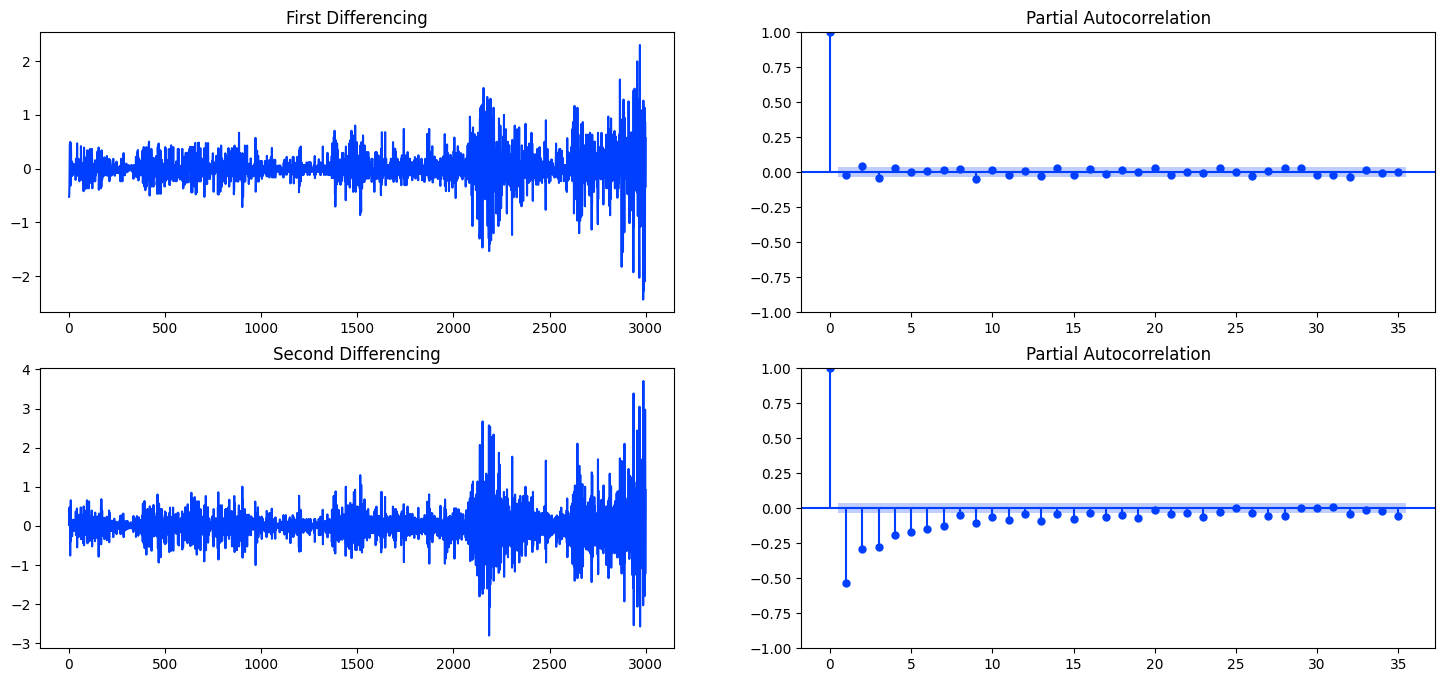

In [11]:
#Plot PACF
fig, ax = plt.subplots(2, 2, figsize=(18,8))

diff_once = train['Close'].diff()
ax[0,0].plot(diff_once.dropna())
ax[0,0].set_title('First Differencing')

plot_pacf(diff_once.dropna(), ax=ax[0,1])

diff_twice = train['Close'].diff().diff()
ax[1,0].plot(diff_twice.dropna())
ax[1,0].set_title('Second Differencing')

plot_pacf(diff_twice.dropna(), ax=ax[1,1])

plt.show()

In [12]:
ndiffs(train['Close'], test='adf')

1

In [13]:
result = adfuller(train['Close'].diff().dropna())
print(f'ADF Stattistics : {result[0]}')
print(f'P-value : {result[1]}')

result_kpss = kpss(train['Close'].diff().dropna())
print(f'\nKPSS Stattistics : {result_kpss[0]}')
print(f'P-value : {result_kpss[1]}')

if result[1] < 0.05 and result_kpss[1] > 0.05:
  print('\nConclusion : Data stationer\n')
else:
  print('\nConclusion : Data not stationer\n')

ADF Stattistics : -26.755572440322442
P-value : 0.0

KPSS Stattistics : 0.24200578033073453
P-value : 0.1

Conclusion : Data stationer



C:\Users\DELL\AppData\Local\Temp\ipykernel_18808\263714489.py:5: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




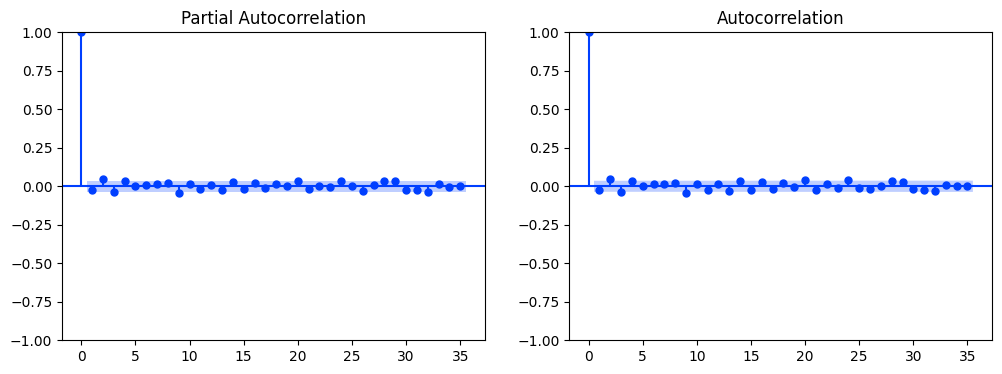

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

diff_once = train['Close'].diff()
plot_pacf(diff_once.dropna(), ax=ax[0])
plot_acf(diff_once.dropna(), ax=ax[1])

plt.show()

# **MODELING**


**ARIMA(1,1,1)**

In [15]:
model1 = ARIMA(train['Close'], order=(1, 1, 1), trend='t')
result1 = model1.fit()
print(result1.summary())

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3000
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -765.763
Date:                Thu, 14 Mar 2024   AIC                           1539.525
Time:                        18:06:32   BIC                           1563.549
Sample:                             0   HQIC                          1548.167
                               - 3000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0063      0.006      1.100      0.271      -0.005       0.017
ar.L1         -0.9564      0.014    -70.602      0.000      -0.983      -0.930
ma.L1          0.9314      0.016     56.624      0.0

**ARIMA(0,1,1)**

In [16]:
model2 = ARIMA(train['Close'], order=(0, 1, 1), trend='t')
result2 = model2.fit()
print(result2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3000
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -776.156
Date:                Thu, 14 Mar 2024   AIC                           1558.311
Time:                        18:06:35   BIC                           1576.329
Sample:                             0   HQIC                          1564.792
                               - 3000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0062      0.006      1.080      0.280      -0.005       0.018
ma.L1         -0.0197      0.009     -2.119      0.034      -0.038      -0.001
sigma2         0.0982      0.001     91.917      0.0

**ARIMA(1,1,0)**

In [17]:
model3 = ARIMA(train['Close'], order=(1, 1, 0), trend='t')
result3 = model3.fit()
print(result3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3000
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -776.097
Date:                Thu, 14 Mar 2024   AIC                           1558.194
Time:                        18:06:38   BIC                           1576.212
Sample:                             0   HQIC                          1564.675
                               - 3000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0063      0.006      1.084      0.278      -0.005       0.018
ar.L1         -0.0215      0.009     -2.311      0.021      -0.040      -0.003
sigma2         0.0982      0.001     91.938      0.0

# **FORCASTING**

In [18]:
#Prediction
prediction_arima = result1.get_prediction(start=1, end=len(ctg))
pred = prediction_arima.predicted_mean

pred_df = pd.DataFrame(pred.values, columns=['pred']).join(ctg['Date'])

In [19]:
#Forecast Next 100 Days
n_forecast = 100

forecast_arima = result1.get_forecast(steps=n_forecast)

yhat = forecast_arima.predicted_mean
yhat_conf_int = forecast_arima.conf_int(alpha=0.05)

yhat_date = pd.DataFrame(pd.date_range(start = '2024-03-13', periods = 100, freq='B'), columns=['Date'])

yhat_df = pd.DataFrame(yhat.values,  columns=['yhat']).join(yhat_date)

In [20]:
# Result Forecast
yhat_df

,yhat,Date
0,29.280582,2024-03-13
1,29.265504,2024-03-14
2,29.292155,2024-03-15
3,29.278895,2024-03-18
4,29.303808,2024-03-19
...,...,...
95,29.863386,2024-07-24
96,29.869948,2024-07-25
97,29.875902,2024-07-26
98,29.882437,2024-07-29


In [21]:
lower_series = pd.DataFrame(yhat_conf_int['lower Close'].values, columns=['lower']).join(yhat_date)
upper_series = pd.DataFrame(yhat_conf_int['upper Close'].values, columns=['upper']).join(yhat_date)

In [22]:
pio.templates.default = "plotly_white"

st_fig = go.Figure()

st_fig.add_trace(go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train'))
st_fig.add_trace(go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test'))

st_fig.add_trace(go.Scatter(x = pred_df['Date'], y = pred_df['pred'], 
                            line = dict(color='firebrick', width=2, dash='dot'), name= 'Prediction'))
st_fig.add_trace(go.Scatter(x = yhat_df['Date'], y = yhat_df['yhat'], 
                            line = dict(color='firebrick', width=2, dash='dot'), name= 'Forecasting'))

st_fig.add_traces(go.Scatter(x=lower_series['Date'], y = lower_series['lower'],
                          line = dict(color='#d5dbd6'), name='lower'))
st_fig.add_traces(go.Scatter(x=upper_series['Date'], y = upper_series['upper'],
                          line = dict(color='#d5dbd6'),
                          fill='tonexty', name='upper'))

st_fig.update_layout(title='ARIMA (0,1,1)')
st_fig.show()

In [23]:
rmse_arima =  mean_squared_error(test['Close'], pred_df['pred'][split_time:], squared=False)
rmse_arima

5.659172963298819

# **FB Prophet Model**

In [24]:
train_fp = pd.DataFrame({'ds' : train['Date'], 'y' : train['Close']})
train_fp

,ds,y
0,2009-07-16,10.496170
1,2009-07-17,9.972637
2,2009-07-20,9.475024
3,2009-07-21,9.135040
4,2009-07-22,9.265632
...,...,...
2995,2021-07-16,30.256210
2996,2021-07-19,28.160540
2997,2021-07-20,29.033730
2998,2021-07-21,28.684460


In [25]:
model_fp = Prophet(daily_seasonality=True)
model_fp.fit(train_fp)

18:07:03 - cmdstanpy - INFO - Chain [1] start processing
18:07:06 - cmdstanpy - INFO - Chain [1] done processing


# **Forecast**

In [26]:
future = model_fp.make_future_dataframe(periods=len(test)+100, freq='B')
future

,ds
0,2009-07-16
1,2009-07-17
2,2009-07-20
3,2009-07-21
4,2009-07-22
...,...
3754,2024-06-13
3755,2024-06-14
3756,2024-06-17
3757,2024-06-18


In [27]:
forecast = model_fp.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3754,2024-06-13,48.069691,29.850080,64.437604
3755,2024-06-14,48.094652,29.526475,64.472902
3756,2024-06-17,48.092953,29.037465,64.229817
3757,2024-06-18,48.100131,29.367313,64.271241
3758,2024-06-19,48.124793,29.630453,64.838196


In [28]:
pio.templates.default = "plotly_white"

st_fig = go.Figure()


st_fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat_lower'],
                          line = dict(color='#d5dbd6'), name='lower'))
st_fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat_upper'],
                          line = dict(color='#d5dbd6'),
                          fill='tonexty', name='upper'))

st_fig.add_trace(go.Scatter(x = train['Date'], y = train['Close'], mode = 'lines', name = 'Train'))
st_fig.add_trace(go.Scatter(x = test['Date'], y = test['Close'], mode = 'lines', name= 'Test'))

st_fig.add_trace(go.Scatter(x = forecast['ds'], y = forecast['yhat'], 
                            line = dict(color='green', width=2, dash='dot'), name= 'Forecasting'))


st_fig.update_layout(title='FB Prophet')
st_fig.show()

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



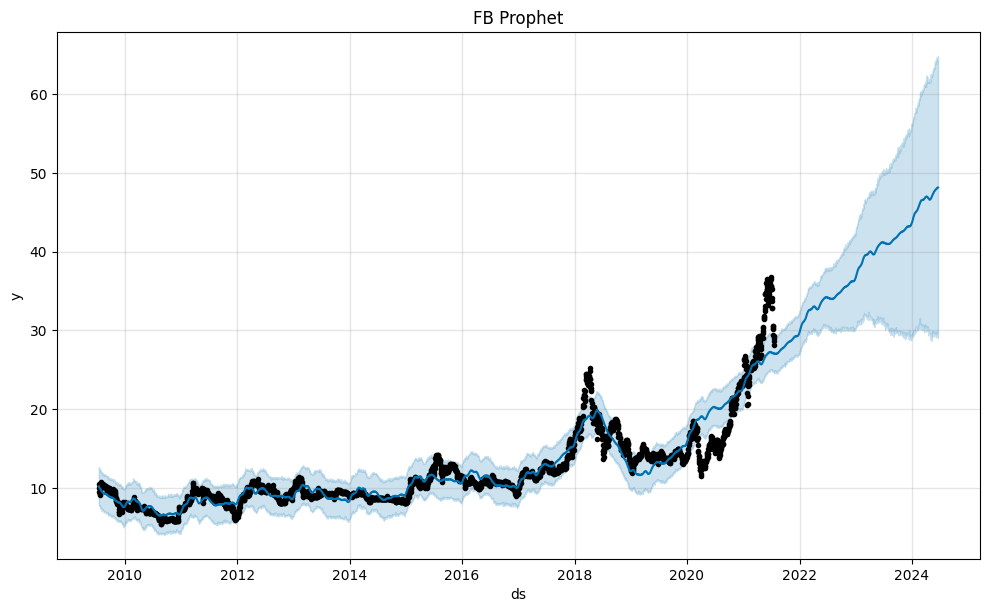

In [29]:
model_fp.plot(forecast)
plt.title('FB Prophet')
plt.show()

In [30]:
rmse_fp =  mean_squared_error(test['Close'], forecast['yhat'][split_time:split_time+len(test)], squared=False)
rmse_fp

10.906124136192972